In [18]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer,FreezeCoreTransformer
import numpy as np
from qiskit.algorithms.optimizers import SLSQP
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
from qiskit.algorithms.minimum_eigensolvers import AdaptVQE
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit.circuit import QuantumCircuit
from copy import  deepcopy
from qiskit.circuit import Parameter,ParameterVector
import sys
sys.path.append('..')
from AdaptVQE_.My_adapt import MyG_AdaotVQE,MyAdaptVQE
# Define Molecule
molecule = MoleculeInfo(
    ["Li", "H"], [(0.0, 0.0, 0.0), (0.8*1, 0.0, 0.0)],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)
driver = PySCFDriver().from_molecule(molecule)

problem = driver.run()
converter = QubitConverter(JordanWignerMapper(), two_qubit_reduction=True)
transformer = FreezeCoreTransformer(
    freeze_core=True,  # how many electrons we have in our active space
    # how many orbitals we have in our active space
    remove_orbitals=[-3, -2]
)
#problem = transformer.transform(problem=problem)

In [30]:
from qiskit_nature.second_q.circuit.library import UCC,HartreeFock
from qiskit.circuit.library import EvolvedOperatorAnsatz

uccsd = UCC(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,excitations='sd',\
    generalized=False)
uccgsd = UCC(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,excitations='sd',\
    generalized=True)
uccgd = UCC(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,excitations='d',\
    generalized=True)
uccd = UCC(num_spatial_orbitals=problem.num_spatial_orbitals,num_particles=problem.num_particles,excitations='d',\
    generalized=False)
HF = HartreeFock(num_particles=problem.num_particles,num_spatial_orbitals=problem.num_spatial_orbitals,qubit_converter=converter)

uccsd_secondop = [converter.convert(i) for i in uccsd.excitation_ops()] #117
uccgsd_secondop = [converter.convert(i) for i in uccgsd.excitation_ops()] #285
uccgd_secondop = [converter.convert(i) for i in uccgd.excitation_ops()] #255
uccd_secondop = [converter.convert(i) for i in uccd.excitation_ops()] #255
##
uccsd_secondop_pool = [EvolvedOperatorAnsatz(operators=i, insert_barriers=True, name='SD_'+str(index), parameter_prefix='SD_'+str(index)).to_instruction()\
                                                for index, i in enumerate(uccsd_secondop)]
uccgsd_secondop_pool = [EvolvedOperatorAnsatz(operators=i, insert_barriers=True, name='GSD_'+str(index), parameter_prefix='GSD_'+str(index)).to_instruction()\
                                                for index, i in enumerate(uccgsd_secondop)]
uccgd_secondop_pool = [EvolvedOperatorAnsatz(operators=i, insert_barriers=True, name='GD_'+str(index), parameter_prefix='GD_'+str(index)).to_instruction()\
                                                for index, i in enumerate(uccgd_secondop)]

UCCSD:92,UCCGSD:555


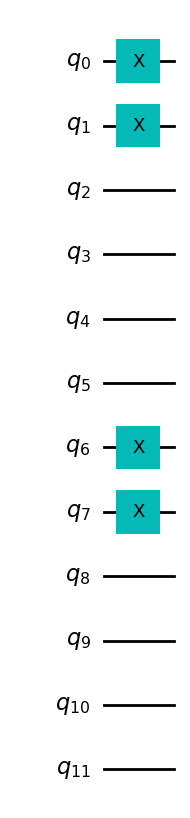

In [31]:
print(f'UCCSD:{len(uccsd_secondop)},UCCGSD:{len(uccgsd_secondop)}')
display(HF.draw('mpl'))
# print(f'UCCD:\n{uccd.excitation_list}\nUCCGD:\n{uccgd.excitation_list}')
T = [i for i in uccsd.excitation_list if i not in uccgsd.excitation_list]#在UCCSD里,不在UCCGSD里

In [32]:
T
#print(uccsd.initial_state)

[((0, 1), (2, 3)),
 ((0, 1), (2, 4)),
 ((0, 1), (2, 5)),
 ((0, 1), (3, 4)),
 ((0, 1), (3, 5)),
 ((0, 1), (4, 5)),
 ((6, 7), (8, 9)),
 ((6, 7), (8, 10)),
 ((6, 7), (8, 11)),
 ((6, 7), (9, 10)),
 ((6, 7), (9, 11)),
 ((6, 7), (10, 11))]

In [22]:
uccd.excitation_list
uccgd.excitation_list

[((0, 2), (1, 3)),
 ((0, 2), (1, 4)),
 ((0, 2), (1, 5)),
 ((0, 3), (1, 4)),
 ((0, 3), (1, 5)),
 ((0, 4), (1, 5)),
 ((0, 6), (1, 7)),
 ((0, 6), (1, 8)),
 ((0, 6), (1, 9)),
 ((0, 6), (1, 10)),
 ((0, 6), (1, 11)),
 ((0, 7), (1, 8)),
 ((0, 7), (1, 9)),
 ((0, 7), (1, 10)),
 ((0, 7), (1, 11)),
 ((0, 8), (1, 9)),
 ((0, 8), (1, 10)),
 ((0, 8), (1, 11)),
 ((0, 9), (1, 10)),
 ((0, 9), (1, 11)),
 ((0, 10), (1, 11)),
 ((0, 3), (2, 4)),
 ((0, 3), (2, 5)),
 ((0, 4), (2, 5)),
 ((0, 6), (2, 7)),
 ((0, 6), (2, 8)),
 ((0, 6), (2, 9)),
 ((0, 6), (2, 10)),
 ((0, 6), (2, 11)),
 ((0, 7), (2, 8)),
 ((0, 7), (2, 9)),
 ((0, 7), (2, 10)),
 ((0, 7), (2, 11)),
 ((0, 8), (2, 9)),
 ((0, 8), (2, 10)),
 ((0, 8), (2, 11)),
 ((0, 9), (2, 10)),
 ((0, 9), (2, 11)),
 ((0, 10), (2, 11)),
 ((0, 4), (3, 5)),
 ((0, 6), (3, 7)),
 ((0, 6), (3, 8)),
 ((0, 6), (3, 9)),
 ((0, 6), (3, 10)),
 ((0, 6), (3, 11)),
 ((0, 7), (3, 8)),
 ((0, 7), (3, 9)),
 ((0, 7), (3, 10)),
 ((0, 7), (3, 11)),
 ((0, 8), (3, 9)),
 ((0, 8), (3, 10)),
 ((0, 

In [10]:
uccsd.excitation_list[0]

((0,), (2,))